In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta

sns.set()

In [2]:
df = pd.read_csv('gpt_sentiment.csv')
# adding in field for date of earnings release
df = pd.merge(df, pd.read_csv('EarningsTranscriptData.txt').drop('content', axis=1), 'left', left_on=['symbol', 'quarter', 'year'], right_on=['symbol', 'quarter', 'year'])
# adjusting UTC time for CST
df['date_cst'] = df.date.apply(lambda x: pd.to_datetime(x) - timedelta(hours=5))
# adjusting the actual date for releases before/after market hours
df['date_adj'] = pd.to_datetime(df.date_cst.apply(lambda x: x.date() if x.hour <= 15 else (x + timedelta(days=1)).date()))
df.drop(['date', 'date_cst'], axis=1, inplace=True)

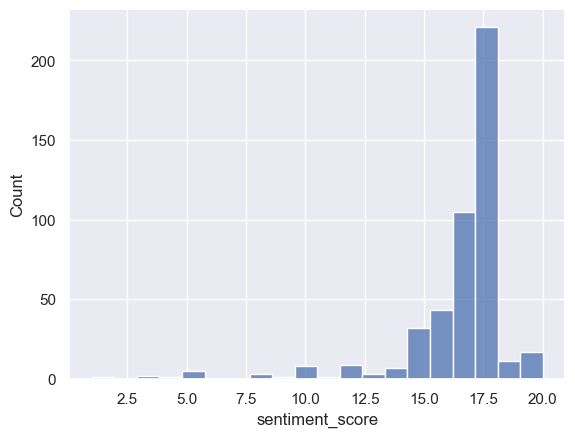

In [3]:
sns.histplot(df.sentiment_score, bins=20);

In [4]:
# pull stock data from yfinance
l_tickers = df.symbol.unique().tolist() + ['SPY']
start_date = '2016-12-30'
end_date = '2023-06-30'

data = yf.download(l_tickers, start_date, end_date)
prices = data['Adj Close'].copy()
returns = prices.pct_change().dropna().copy()

[*********************100%%**********************]  26 of 26 completed


In [5]:
# compute forward active returns
spy_rets = returns.SPY
active_returns = returns.sub(spy_rets, axis='index')
fwd_active_1w = active_returns.rolling(5).sum().shift(-4).dropna().reset_index().melt(id_vars='Date', var_name='symbol', value_name='1wFwdRtn').copy()
fwd_active_1m = active_returns.rolling(21).sum().shift(-20).dropna().reset_index().melt(id_vars='Date', var_name='symbol', value_name='1mFwdRtn').copy()
fwd_active_1q = active_returns.rolling(63).sum().shift(-62).dropna().reset_index().melt(id_vars='Date', var_name='symbol', value_name='1qFwdRtn').copy()

In [6]:
# join to df with sentiment scores
df = pd.merge(df, fwd_active_1w, 'left', left_on=['symbol', 'date_adj'], right_on=['symbol', 'Date'])
df = pd.merge(df, fwd_active_1m, 'left', left_on=['symbol', 'date_adj'], right_on=['symbol', 'Date'])
df = pd.merge(df, fwd_active_1q, 'left', left_on=['symbol', 'date_adj'], right_on=['symbol', 'Date']).drop(['date_adj', 'Date_x', 'Date_y'], axis=1)

<Axes: xlabel='sentiment_score', ylabel='1wFwdRtn'>

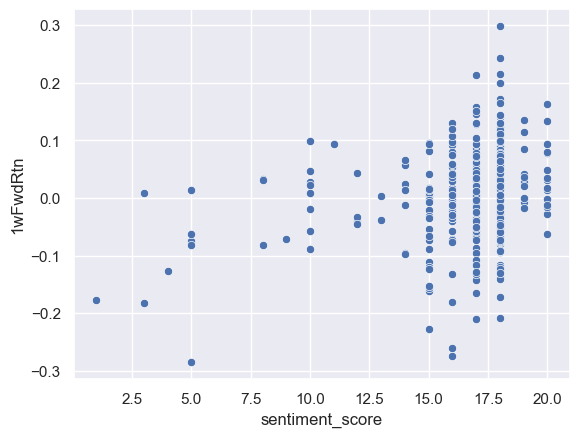

In [7]:
# cross-sectionally
sns.scatterplot(df, x='sentiment_score', y='1wFwdRtn')

In [8]:
# relative to self history
means = df.groupby('symbol')['sentiment_score'].agg(np.mean).copy()
means = means.rename('sent_score_mean')
df_rel = pd.merge(df, means, 'left', left_on='symbol', right_on='symbol')
df_rel['relative_sent_score'] = df_rel.sentiment_score - df_rel.sent_score_mean

<Axes: xlabel='relative_sent_score', ylabel='1wFwdRtn'>

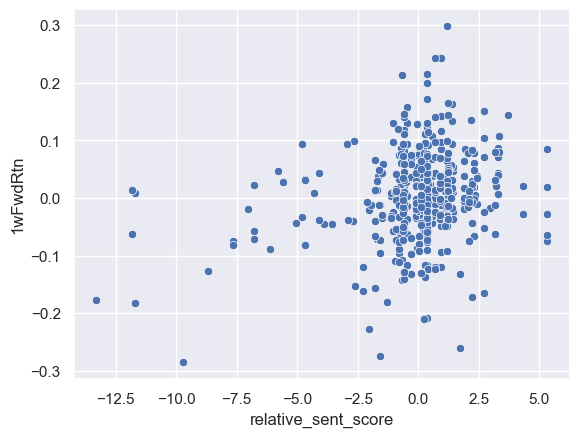

In [9]:
sns.scatterplot(df_rel, x='relative_sent_score', y='1wFwdRtn')

<Axes: xlabel='relative_sent_score', ylabel='1mFwdRtn'>

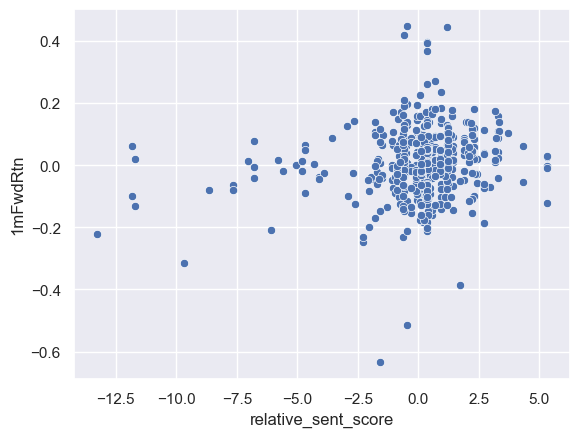

In [10]:
sns.scatterplot(df_rel, x='relative_sent_score', y='1mFwdRtn')

<Axes: xlabel='relative_sent_score', ylabel='1mFwdRtn'>

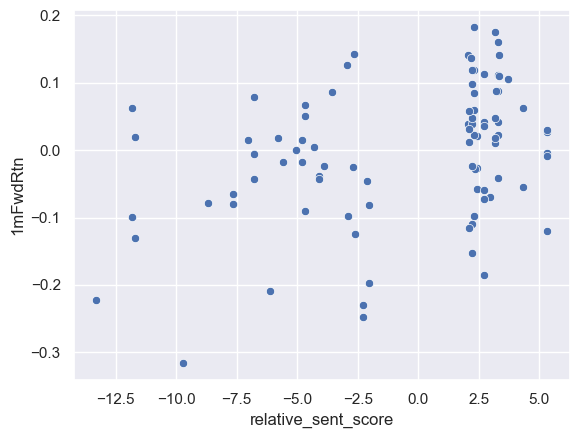

In [11]:
df_masked = df_rel[(df_rel.relative_sent_score <= -2) | (df_rel.relative_sent_score >= 2)].copy()
sns.scatterplot(df_masked, x='relative_sent_score', y='1mFwdRtn')

In [12]:
df_masked['correct_class'] = np.where( ( (df_masked.relative_sent_score <= 2) & (df_masked['1mFwdRtn'] < 0) ) | ( (df_masked.relative_sent_score >= 2) & (df_masked['1mFwdRtn'] > 0) ), 1, 0 )

In [13]:
df_masked.correct_class.sum() / df_masked.correct_class.count()

0.6559139784946236

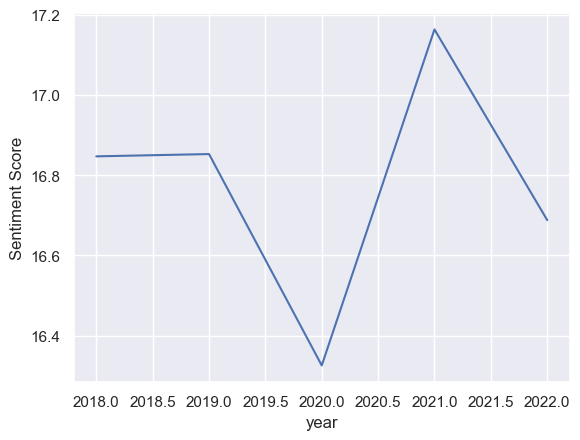

In [22]:
df.groupby('year')['sentiment_score'].agg(np.mean).plot(ylabel='Sentiment Score');